In [1]:
#Installing/importing packages
!pip install -q plotnine
from plotnine import *
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
bg_dt = pd.read_csv('data/all_chr.H.tsv.gz', compression='gzip', 
                                 header=0, sep='\t', index_col = 0) #read data
bg_dt2 = bg_dt.T # transpose data
bg_dt2.index.name = 'SampleID' #change index name to merge later with the manifest
bg_dt2.iloc[1:10,1:10] # check into first ten rows, all looks ok

chr_pos_ref_alt,1:58771:T:C,1:183401:C:G,1:186291:G:A,1:281912:C:G,1:531693:C:T,1:663390:T:C,1:689966:T:C,1:734153:G:C,1:813885:G:A
SampleID,,,,,,,,,
HG00097,1|1,0|0,0|0,0|0,1|1,0|0,0|0,0|0,1|1
HG00099,0|0,0|0,1|0,0|0,0|1,0|0,0|0,0|0,1|1
HG00100,1|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,1|1
HG00101,1|0,0|0,0|0,1|0,0|1,0|0,0|0,0|0,1|0
HG00102,1|1,0|0,0|0,1|0,0|0,0|0,0|0,1|0,1|1
HG00103,0|0,0|0,0|0,0|0,1|1,0|0,0|0,0|0,1|1
HG00105,0|1,0|0,0|0,1|0,0|0,0|0,0|0,0|0,1|1
HG00106,0|1,0|1,0|0,0|0,0|1,0|0,1|0,0|1,1|0
HG00107,1|0,0|0,0|0,1|0,1|1,1|0,0|0,0|0,0|0


In [3]:
manifest = pd.read_csv('data/manifest.txt', sep = " ", index_col= 1) # read the manifest
#print(manifest.head) # fyi how it looks
manifest = manifest[['Population','Superpopulation']] # leave only Pop
#print(manifest.head) # looks fine
bg_dt3 = pd.merge(manifest,bg_dt2, left_index=True, right_index=True) # merge with the data by indices
#bg_dt3

In [5]:
smpl_list = pd.read_csv('data/samples.2561.txt', header=None, index_col = 0) # read samples to be subsetted
#print(smpl_list.head) # check how they look, they are indexes here
#print(bg_dt3.shape) # check the shape of the previos data, 3202 samples and 62.9K SNPs + Pop

In [6]:
train=bg_dt3[bg_dt3.index.isin(smpl_list.index)] # subset the train via train samples
train_Y = train[['Population','Superpopulation']] # get Y stay alone
train_Y.index = range(0,2561) # change to merge it later

train = train.drop('Population', axis = 1) # remove Y from data
train = train.drop('Superpopulation', axis = 1)
print(train.iloc[0:10,0:10]) # check that all is fine
print(train_Y)

         1:17222:A:G 1:58771:T:C 1:183401:C:G 1:186291:G:A 1:281912:C:G  \
SampleID                                                                  
HG00096          0|0         1|0          0|0          0|0          0|0   
HG00099          0|0         0|0          0|0          1|0          0|0   
HG00100          0|0         1|0          0|0          0|0          0|0   
HG00101          0|1         1|0          0|0          0|0          1|0   
HG00102          0|0         1|1          0|0          0|0          1|0   
HG00103          0|0         0|0          0|0          0|0          0|0   
HG00105          0|0         0|1          0|0          0|0          1|0   
HG00107          0|0         1|0          0|0          0|0          1|0   
HG00108          0|0         0|1          0|0          0|0          0|0   
HG00109          0|0         0|0          0|0          0|0          0|0   

         1:531693:C:T 1:663390:T:C 1:689966:T:C 1:734153:G:C 1:813885:G:A  
SampleID               

In [7]:
# recode all genotypes to 0 1 2

train = train.replace(['0|0'], '0')
train = train.replace(['0|1',"1|0"], '1')
train = train.replace(['1|1'], '2')
print(train.iloc[0:10,0:10])

# simple normalisation, I guess I could use StandartScaller, but anyway

train = train.apply(pd.to_numeric) # to numeric
mu = train.mean(axis=(0)) # general mean
std = train.std(axis=(0)) # sd
train_norm = (train - mu)/std # normalisation
#X_test_norm = (X_test - mu)/std # someday the same to the test
#mu # I checked that all looks good

print(train.info()) # and additional check the previos and norm datasets
print(train_norm.iloc[0:10,0:10])

         1:17222:A:G 1:58771:T:C 1:183401:C:G 1:186291:G:A 1:281912:C:G  \
SampleID                                                                  
HG00096            0           1            0            0            0   
HG00099            0           0            0            1            0   
HG00100            0           1            0            0            0   
HG00101            1           1            0            0            1   
HG00102            0           2            0            0            1   
HG00103            0           0            0            0            0   
HG00105            0           1            0            0            1   
HG00107            0           1            0            0            1   
HG00108            0           1            0            0            0   
HG00109            0           0            0            0            0   

         1:531693:C:T 1:663390:T:C 1:689966:T:C 1:734153:G:C 1:813885:G:A  
SampleID               

In [8]:
# workarond: PCA doesn't work since some SNPs had NaN after norm, it seemed they had 0|0 across all samples in train
# but I chose the SNPs used train... anyway, I decided to simple remoce them since it's not many of them

vec = train_norm.isna().any() # the vector contains info if the column contains NaN
vec_T = vec[vec == True] # only TRUE
print(vec_T.index, len(vec_T.index)) # their names and amount

Index(['1:10248540:T:A', '4:22686119:T:A', '4:174674903:T:G', '6:87801487:G:T',
       '6:88803218:T:A', '8:129694056:G:A', '9:27548938:T:C', '9:99352025:C:A',
       '9:121542334:A:T', '11:56953217:A:C', '14:57763802:G:A',
       '15:90603252:C:A', '22:39351776:G:C'],
      dtype='object') 13


In [9]:

train_norm = train_norm.drop(vec_T.index, axis=1)
train_norm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2561 entries, HG00096 to NA21144
Columns: 62886 entries, 1:17222:A:G to 22:50807426:C:T
dtypes: float64(62886)
memory usage: 1.2+ GB


In [10]:

from sklearn.decomposition import PCA
pca_09 = PCA(n_components=0.9)
pca_09.fit(train_norm)
train_norm_new_coord = pca_09.transform(train_norm)

Text(0, 0.5, 'pct variance explained')

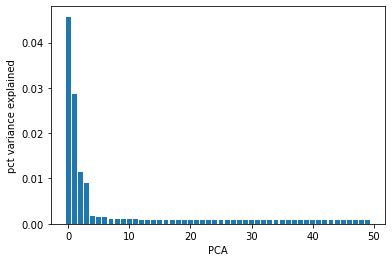

In [11]:
#Plot 1
import matplotlib.pyplot as plt
plt.bar(range(0,50), pca_09.explained_variance_ratio_[0:50])
plt.xlabel('PCA')
plt.ylabel('pct variance explained')

In [12]:
# do a dataset, add normal colnames
toplot = pd.DataFrame(train_norm_new_coord) # nparray to df; I just get used to work with df
train_X = toplot
toplot.columns = ["PC" + str(x) for x in range(1,1898)] # new colnames since right now colnames are RangeIndices
#train_Y.index.name = None
toplot = toplot.join(train_Y)


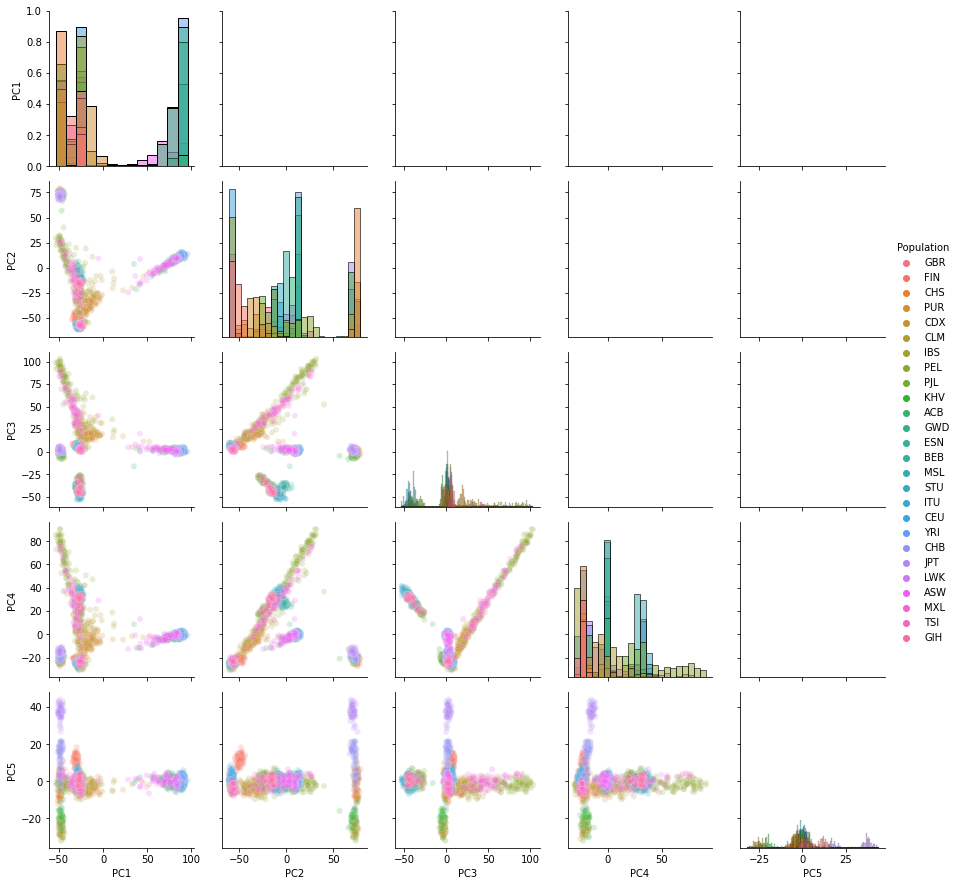

In [13]:
pc_pairplot = toplot.iloc[:,:5]
pc_pairplot['Population'] = toplot['Population']
g = sns.PairGrid(pc_pairplot, hue="Population")
g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot,alpha=0.2)
g.add_legend()
#plt.savefig('pca_population.png', bbox_inches='tight',dpi=300)

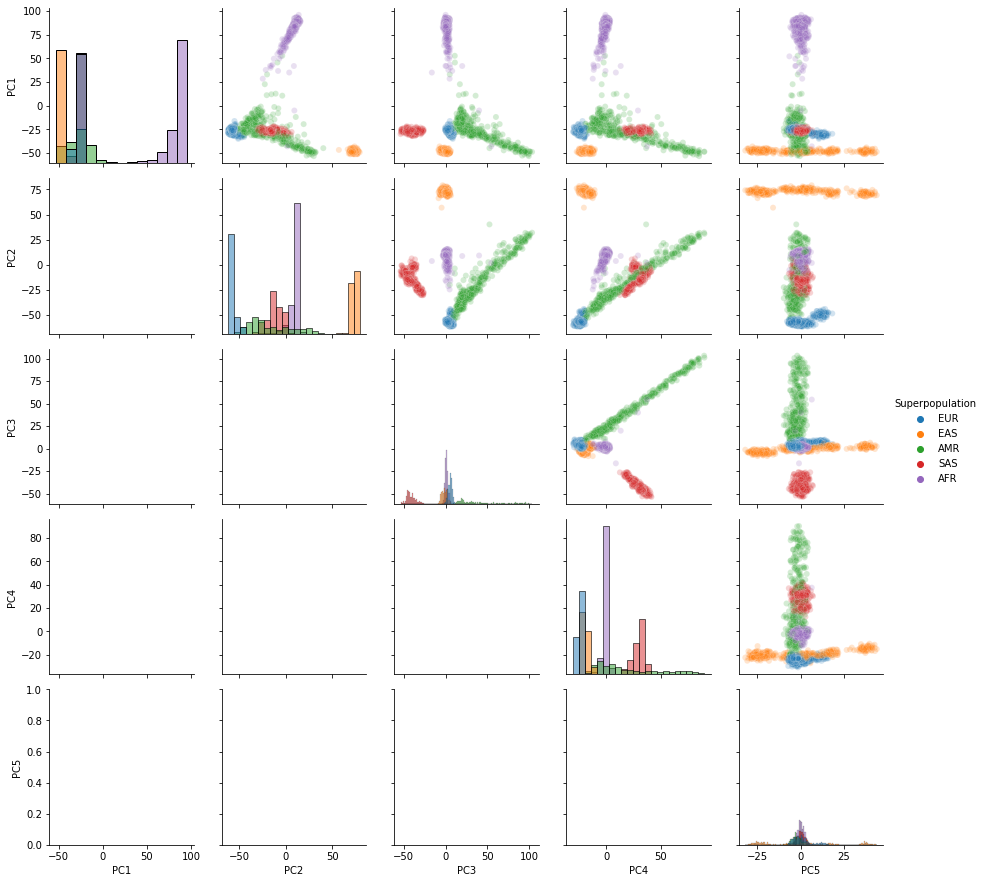

In [14]:
pc_pairplot = toplot.iloc[:,:5]
pc_pairplot['Superpopulation'] = toplot['Superpopulation']
g = sns.PairGrid(pc_pairplot, hue="Superpopulation")
g.map_diag(sns.histplot)
g.map_upper(sns.scatterplot,alpha=0.2)
g.add_legend()
#plt.savefig('pca_superpopulation.png', bbox_inches='tight',dpi=300)

/home/danat/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
/home/danat/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


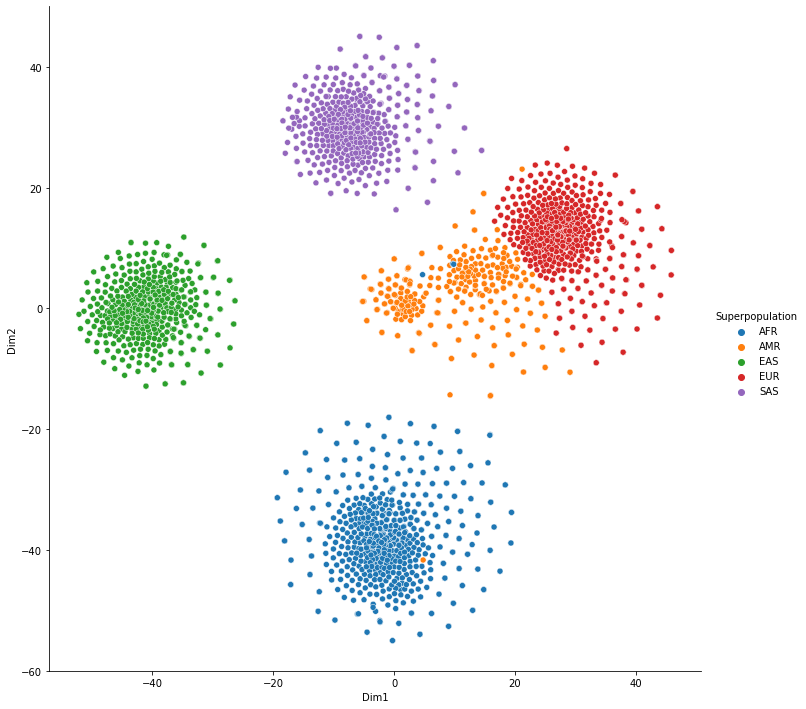

In [20]:

tSNE_def_embedded = TSNE(n_components=2, random_state=404).fit_transform(train_X) 
# 16m - 18m #btw, it's hihly recommended to use dimensions reduction before it, but here I decided to have the clean experiment
visualise_train_tSNE = pd.DataFrame({'Dim1':tSNE_def_embedded.T[0], 'Dim2':tSNE_def_embedded.T[1], 'class': train_Y['Superpopulation']})
visualise_train_tSNE['Superpopulation'] = visualise_train_tSNE['class'].astype("category")

sns.pairplot(data=visualise_train_tSNE, x_vars="Dim1", y_vars="Dim2", hue="Superpopulation",height=10)

#plt.savefig('tsne_population.sup_Pop.all.png', bbox_inches='tight',dpi=300)

/home/danat/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
/home/danat/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


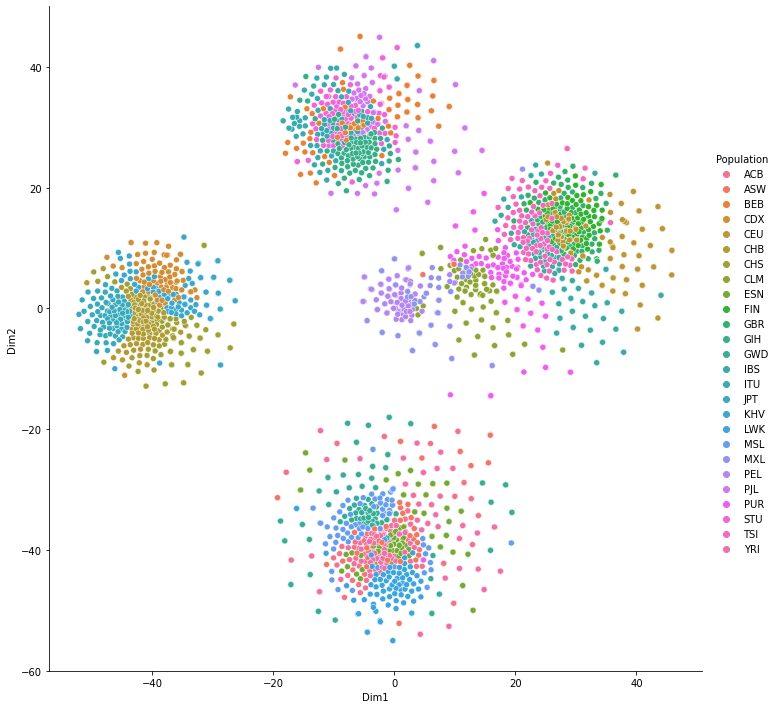

In [21]:

tSNE_def_embedded = TSNE(n_components=2, random_state=404).fit_transform(train_X) 
# 16m - 18m #btw, it's hihly recommended to use dimensions reduction before it, but here I decided to have the clean experiment
visualise_train_tSNE = pd.DataFrame({'Dim1':tSNE_def_embedded.T[0], 'Dim2':tSNE_def_embedded.T[1], 'class': train_Y['Population']})
visualise_train_tSNE['Population'] = visualise_train_tSNE['class'].astype("category")

sns.pairplot(data=visualise_train_tSNE, x_vars="Dim1", y_vars="Dim2", hue="Population",height=10)

#plt.savefig('tsne_population.Pop.all.png', bbox_inches='tight',dpi=300)

/home/danat/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
/home/danat/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


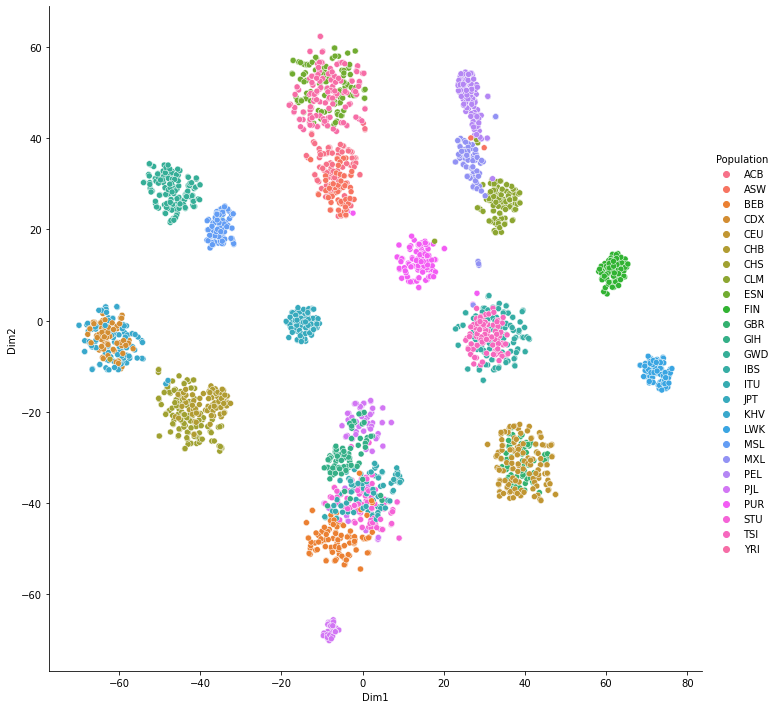

In [15]:

tSNE_def_embedded = TSNE(n_components=2).fit_transform(train_X.iloc[:,:20]) 
# 16m - 18m #btw, it's hihly recommended to use dimensions reduction before it, but here I decided to have the clean experiment
visualise_train_tSNE = pd.DataFrame({'Dim1':tSNE_def_embedded.T[0], 'Dim2':tSNE_def_embedded.T[1], 'class': train_Y['Population']})
visualise_train_tSNE['Population'] = visualise_train_tSNE['class'].astype("category")

sns.pairplot(data=visualise_train_tSNE, x_vars="Dim1", y_vars="Dim2", hue="Population",height=10)

#plt.savefig('tsne_population.png', bbox_inches='tight',dpi=300)